In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, time

git@github.com:wiseodd/generative-models.git

In [ ]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [ ]:
X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, 
                                                                     labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, 
                                                                     labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, 
                                                                labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [1]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
images_dir = 'gan_mnist_tf'

if not os.path.exists(images_dir):
    os.makedirs(images_dir)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Niter, Nimg, Nprnt = 50000, 5000, 5000

t0 = time.time()
mb_size = 128
Z_dim = 100
try:
    for it in range(Niter+1):
        if it % Nimg == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

            fig = plot(samples)
            plt.savefig('{}/{}.png'.format(images_dir, str(it).zfill(5)), bbox_inches='tight')
            plt.close(fig)

        X_mb, _ = mnist.train.next_batch(mb_size)

        _, d_loss, d_real, d_fake = sess.run([D_solver, D_loss, D_real, D_fake], 
                                             feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
        _, g_loss, g_fake = sess.run([G_solver, G_loss, D_fake], 
                                     feed_dict={Z: sample_Z(mb_size, Z_dim)})

        d_acc = 0.5 * ((d_fake[:, 0] < 0.5).sum(0) + (d_real[:, 0] > 0.5).sum(0)) / mb_size
        g_acc = (g_fake[:, 0] > 0.5).sum(0) / mb_size

        if it % Nprnt == 0:
            print('{:6d} -- G: {:.5f}, {:.5f};  D: {:.5f}, {:.5f};  [{:.1f}s]'\
                  .format(it, g_loss, g_acc, d_loss, d_acc, time.time() - t0))
            t0 = time.time()
            
except KeyboardInterrupt:
    print("Interrupted!")
    

     0 -- G: 1.70015, 0.00000;  D: 1.62178, 0.48828;  [1.9s]
  5000 -- G: 4.72364, 0.02344;  D: 0.13189, 0.98047;  [61.3s]
 10000 -- G: 2.85139, 0.10156;  D: 0.47248, 0.90234;  [61.4s]
 15000 -- G: 2.21601, 0.09375;  D: 0.53677, 0.89844;  [61.9s]
 20000 -- G: 2.03503, 0.09375;  D: 0.74889, 0.83203;  [61.5s]
 25000 -- G: 2.05303, 0.10156;  D: 0.68718, 0.82031;  [62.8s]
 30000 -- G: 2.37480, 0.12500;  D: 0.68632, 0.85547;  [62.2s]
 35000 -- G: 2.35672, 0.14062;  D: 0.67175, 0.82812;  [64.5s]
 40000 -- G: 2.34405, 0.10938;  D: 0.65919, 0.84766;  [65.0s]
 45000 -- G: 2.17380, 0.10938;  D: 0.58685, 0.87891;  [64.2s]
 50000 -- G: 2.25068, 0.08594;  D: 0.54244, 0.86719;  [63.4s]


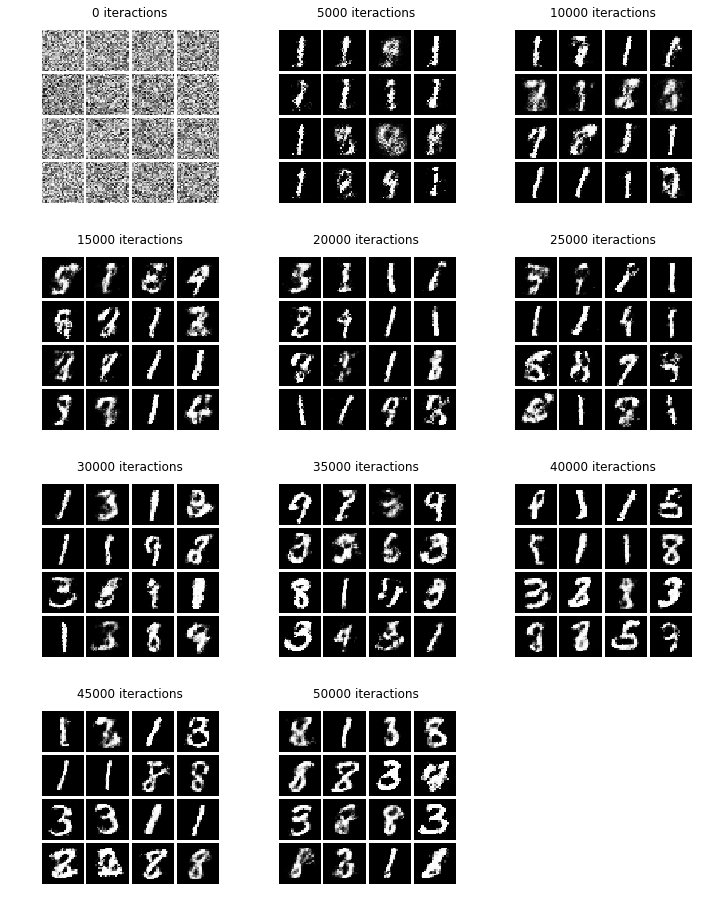

In [3]:
m = int(np.ceil(((Niter+1) // Nimg + 1) / 3))
fig = plt.figure(figsize=(12, 4*m))

shape = (100, 100)
for i, fn in enumerate(range(0, Niter+1, Nimg)):
    fig.add_subplot(m, 3, i+1)
    image_fn = '{}/{:05d}.png'.format(imgages_dir, fn)
    if os.path.isfile(image_fn):
        img = plt.imread(image_fn)
        shape = img.shape
    except:
        img = np.zeros(shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('{} iteractions'.format(fn))
    
plt.show()